In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
dt = pd.read_csv('car_prices.csv')

# DATE PROCESSING

# extract exact date
dt['parsed_date'] = pd.to_datetime(dt['saledate'], errors='coerce', utc=True)
dt = dt.dropna(subset=['parsed_date'])
dt['date'] = dt['parsed_date'].dt.strftime('%Y-%m-%d')
dt['date'] = pd.to_datetime(dt['date'])

# delete useless columns
dt = dt.drop(columns = ['saledate','parsed_date'])

# extract year, week and day
dt['YEAR'] = dt['year']
dt = dt.drop(columns = ['year'])

dt['month'] = dt['date'].dt.month
dt['day'] = dt['date'].dt.day
dt['weekday'] = dt['date'].dt.day_name()

# real date
dt['DATE'] = pd.to_datetime(dt[['YEAR', 'month', 'day']])
dt = dt.drop(columns = ['date'])

dt.head()

/var/folders/_g/n8cgq37145zbzhr4scl00zjc0000gn/T/ipykernel_27864/3661694067.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt['parsed_date'] = pd.to_datetime(dt['saledate'], errors='coerce', utc=True)


,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,YEAR,month,day,weekday,DATE
0,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,2015,12,16,Tuesday,2015-12-16
1,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,2015,12,16,Tuesday,2015-12-16
2,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,2014,1,14,Wednesday,2014-01-14
3,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,2015,1,28,Wednesday,2015-01-28
4,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,2014,12,18,Thursday,2014-12-18


In [98]:
# FEATURE SELECTION

dt_1 = dt.drop(columns = ['model','trim','body','transmission','vin','color','interior','mmr'])
dt_1.dtypes

make                    object
state                   object
condition              float64
odometer               float64
seller                  object
sellingprice           float64
YEAR                     int64
month                    int32
day                      int32
weekday                 object
DATE            datetime64[ns]
dtype: object

In [66]:
'''
pd.set_option('display.max_rows', None)
print(dt_1['YEAR'].value_counts(dropna=False).sort_values(ascending=False))
pd.reset_option('display.max_rows')
'''

YEAR
2012    102313
2013     98160
2014     81068
2011     48548
2008     31502
2007     30845
2006     26913
2010     26485
2005     21394
2009     20594
2004     17342
2003     13281
2002      9715
2015      9411
2001      6468
2000      5227
1999      3363
1998      2149
1997      1546
1996       851
1995       711
1994       392
1993       205
1992       132
1991        67
1990        49
1989        20
1986        11
1988        11
1985        10
1987         8
1984         5
1982         2
1983         1
Name: count, dtype: int64


In [102]:
dt_2 = dt_1[~dt_1['YEAR'].isin([1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,2015])]
print(dt_2['YEAR'].value_counts(dropna=False).sort_values(ascending=False))

YEAR
2012    102313
2013     98160
2014     81068
2011     48548
2008     31502
2007     30845
2006     26913
2010     26485
2005     21394
2009     20594
2004     17342
2003     13281
2002      9715
2001      6468
2000      5227
1999      3363
1998      2149
1997      1546
1996       851
1995       711
Name: count, dtype: int64


In [104]:
pivot_year = dt_2.pivot_table(index='YEAR', aggfunc='size')
pivot_year

YEAR
1995       711
1996       851
1997      1546
1998      2149
1999      3363
2000      5227
2001      6468
2002      9715
2003     13281
2004     17342
2005     21394
2006     26913
2007     30845
2008     31502
2009     20594
2010     26485
2011     48548
2012    102313
2013     98160
2014     81068
dtype: int64

2015-01-01    82939.282153
2016-01-01    84716.069174
2017-01-01    86492.856195
2018-01-01    88269.643216
2019-01-01    90046.430237
Freq: YS-JAN, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


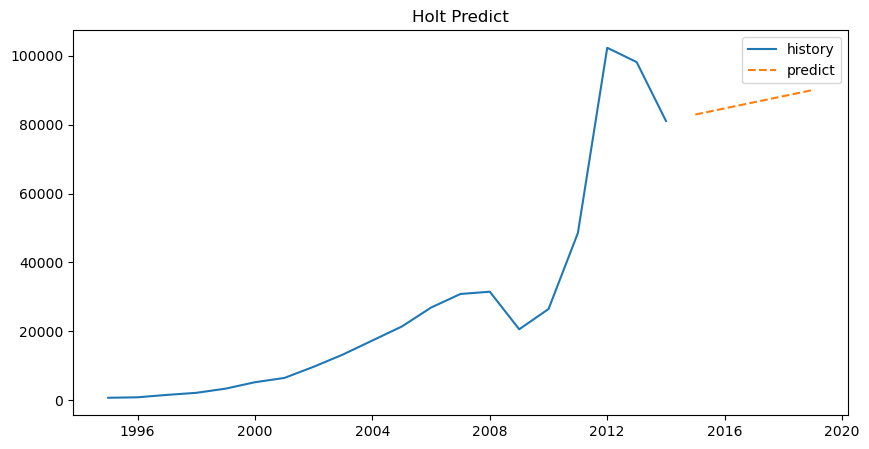

In [106]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

pivot_year.index = pd.to_datetime(pivot_year.index, format='%Y')

model = ExponentialSmoothing(pivot_year, trend='add', seasonal=None)
fit = model.fit()

forecast = fit.forecast(5)
print(forecast)

plt.figure(figsize=(10,5))
plt.plot(pivot_year, label='history')
plt.plot(forecast, label='predict', linestyle='--')
plt.title('Holt Predict')
plt.legend()
plt.show()

In [221]:
dt_3 = dt_2
pivot_month = dt_3.pivot_table(index=['YEAR','month'], aggfunc='size')
pivot_month = pivot_month.reset_index(name='count')
pivot_month = pivot_month[pivot_month['month'] != 7]
pivot_month = pivot_month.reset_index(drop=True)
pivot_month

,YEAR,month,count
0,1995,1,193
1,1995,2,203
2,1995,3,52
3,1995,4,4
4,1995,5,61
...,...,...,...
135,2014,3,7572
136,2014,4,201
137,2014,5,8279
138,2014,6,15418


In [223]:
pivot_month['date'] = pd.to_datetime(pivot_month[['YEAR', 'month']].assign(DAY=1))
pivot_month

,YEAR,month,count,date
0,1995,1,193,1995-01-01
1,1995,2,203,1995-02-01
2,1995,3,52,1995-03-01
3,1995,4,4,1995-04-01
4,1995,5,61,1995-05-01
...,...,...,...,...
135,2014,3,7572,2014-03-01
136,2014,4,201,2014-04-01
137,2014,5,8279,2014-05-01
138,2014,6,15418,2014-06-01


In [261]:
model = ExponentialSmoothing(pivot_month["count"], trend="add", seasonal="add", seasonal_periods=35)
fit = model.fit()

future_steps = 35
forecast = fit.forecast(future_steps)

months = [1, 2, 3, 4, 5, 6, 12]


start_year = 2015
n_years = len(forecast) // len(months)

years = [start_year + i for i in range(n_years) for _ in range(len(months))]

expanded_months = months * n_years

df_forecast = pd.DataFrame({
    'YEAR': years,
    'month': expanded_months,
    'count': forecast.values
})

df_forecast['count'] = df_forecast['count'].clip(lower=0)

df_forecast['date'] = pd.to_datetime(df_forecast[['YEAR', 'month']].assign(day=1))
df_forecast

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,YEAR,month,count,date
0,2015,1,13928.157363,2015-01-01
1,2015,2,14486.226777,2015-02-01
2,2015,3,10657.637863,2015-03-01
3,2015,4,9266.827593,2015-04-01
4,2015,5,10651.204376,2015-05-01
5,2015,6,11474.058024,2015-06-01
6,2015,12,11192.963992,2015-12-01
7,2016,1,16867.915730,2016-01-01
8,2016,2,17221.836480,2016-02-01
9,2016,3,11158.913507,2016-03-01


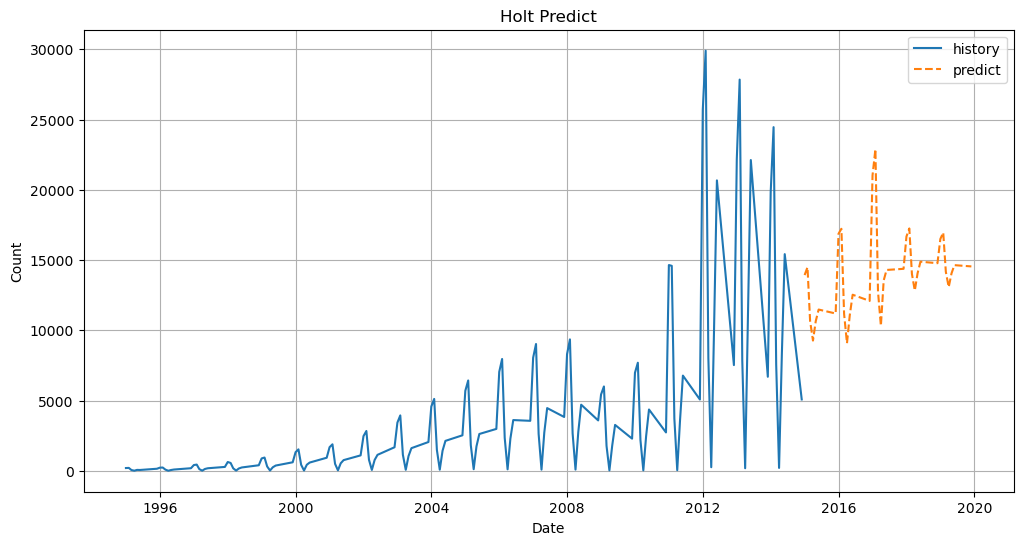

In [263]:
plt.figure(figsize=(12, 6))
plt.plot(pivot_month['date'], pivot_month['count'], label='history')
plt.plot(df_forecast['date'], df_forecast['count'], label='predict', linestyle='--')
plt.title('Holt Predict')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()